In [12]:
#Data Understanding and Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


N-gram

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

ngram_df = pd.read_csv('Preprocessed.csv')
# List to store the n-gram feature DataFrames for each text column
ngram_dfs = []

# Iterate over each text column
for column in ngram_df.select_dtypes(include=['object']).columns:
    # Fill missing values with an empty string
    corpus = ngram_df[column].fillna('').tolist()

    # Initialize CountVectorizer for n-grams
    vectorizer = CountVectorizer(ngram_range=(1, 3))  # Adjust n-gram range as needed

    # Fit and transform the corpus
    X = vectorizer.fit_transform(corpus)

    # Convert the result into a DataFrame
    ngram_features_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    # Concatenate the n-gram features DataFrame with the original DataFrame
   # ngram_df_with_features = pd.concat([ngram_df, ngram_features_df], axis=1)

    # Append the DataFrame with n-gram features to the list
    #ngram_dfs.append(ngram_df_with_features)

# Concatenate all DataFrames in the list along the column axis
#ngram_df_final = pd.concat(ngram_dfs, axis=1)



Below we perform a sentiment analysis

In [9]:
sentiment_df = pd.read_csv('balanced_subset.csv')


In [11]:
from textblob import TextBlob

# Function to apply sentiment analysis
def analyze_sentiment(text):
    testimonial = TextBlob(text)
    return testimonial.sentiment.polarity, testimonial.sentiment.subjectivity

# Applying sentiment analysis to the 'cleaned_text' and 'cleaned_title' columns
sentiment_df['text_polarity'], sentiment_df['text_subjectivity'] = zip(*sentiment_df['cleaned_text'].apply(analyze_sentiment))
sentiment_df['title_polarity'], sentiment_df['title_subjectivity'] = zip(*sentiment_df['cleaned_title'].apply(analyze_sentiment))

print(sentiment_df.head())



   label                                       cleaned_text  cleaned_subject  \
0      1  antonin scalia one reliable conservative u sup...  government news   
1      0  reuters kansa vowed wednesday sue obama admini...     politicsnews   
2      1  rtformer congressman ron paul revealed list fa...           usnews   
3      1  thing looking good donald trump hillary clinto...             news   
4      1  donald trump twitter account littered insult i...             news   

                                       cleaned_title  token_count  \
0  breaking u supreme court justice antonin scali...           72   
1  kansa latest u state challenge obama transgend...           71   
2  ron paul highlight real list mainstream fake n...           73   
3  watch hillary ruin trump right outside bankrup...           71   
4  report aide take away donald trump twitter acc...           89   

   text_polarity  text_subjectivity  title_polarity  title_subjectivity  
0       0.169859           0.4

To better interpret the both subjectivity and polarity of the titles and the text in the articles, we have created a scatter plot diagram below containing all data combined:

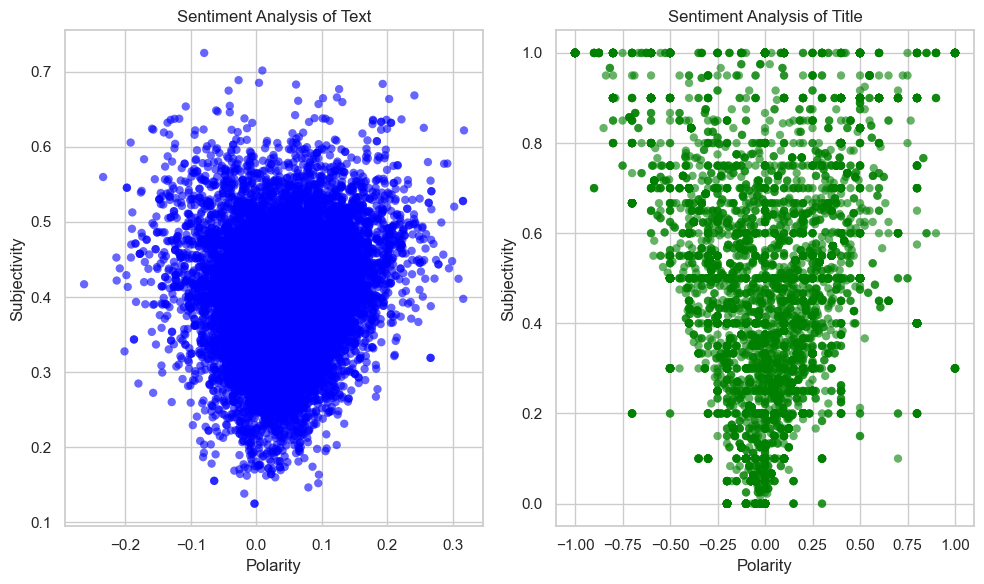

In [13]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a scatter plot for text sentiment
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.scatterplot(x='text_polarity', y='text_subjectivity', data=sentiment_df, alpha=0.6, edgecolor='none', color='blue')
plt.title('Sentiment Analysis of Text')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

# Create a scatter plot for title sentiment
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.scatterplot(x='title_polarity', y='title_subjectivity', data=sentiment_df, alpha=0.6, edgecolor='none', color='green')
plt.title('Sentiment Analysis of Title')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


To further our understanding of the sentiment in the articles, we have further elaborated on the scatter plot, to enabling a 
distinction between fake and real news.

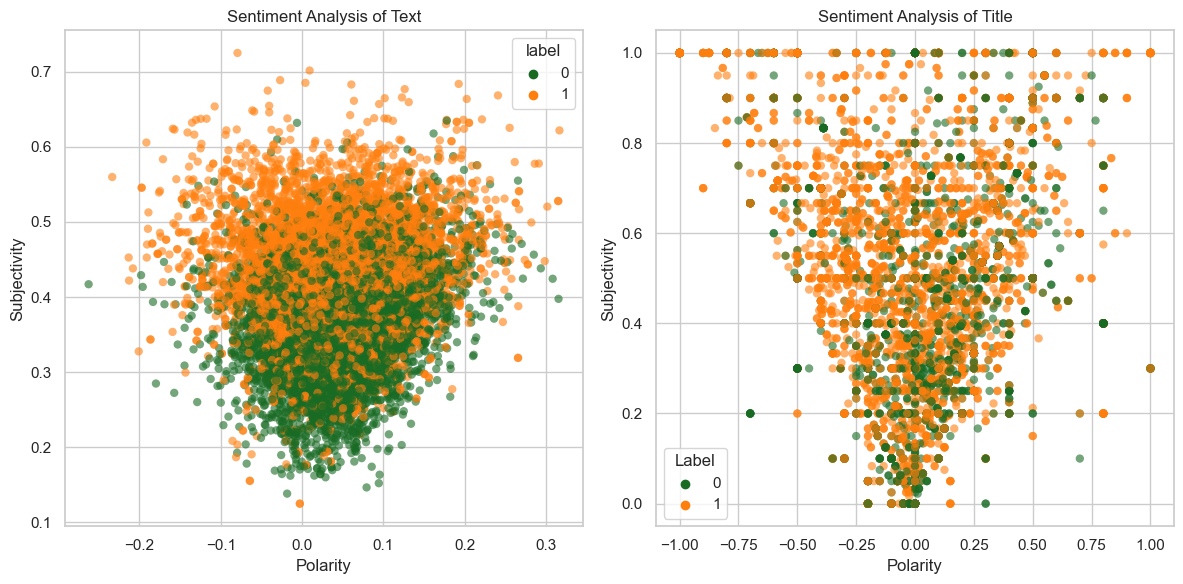

In [19]:
# Prepare the figure to host two plots
plt.figure(figsize=(12, 6))

custom_palette = ['#196B24', '#FF7F0E']  # Purple and blue

# Scatter plot for sentiment analysis of text
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.scatterplot(x='text_polarity', y='text_subjectivity', hue='label', data=sentiment_df, palette=custom_palette, alpha=0.6, edgecolor='none')
plt.title('Sentiment Analysis of Text')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

# Scatter plot for sentiment analysis of title
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.scatterplot(x='title_polarity', y='title_subjectivity', hue='label', data=sentiment_df, palette=custom_palette, alpha=0.6, edgecolor='none')
plt.title('Sentiment Analysis of Title')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

# Add a legend and show the plot
plt.legend(title='Label')
plt.tight_layout()
plt.show()
